## 1. Постановка задачи

<center> <img src=https://storage.googleapis.com/kaggle-competitions/kaggle/3333/media/taxi_meter.png align="right" width="300"/> </center>
    
Вам предстоит решить настоящую задачу машинного обучения, направленную на автоматизацию бизнес процессов. Мы построим модель, которая будет предсказывать общую продолжительность поездки такси в Нью-Йорке.

Представьте вы заказываете такси из одной точки Нью-Йорка в другую, причем не обязательно конечная точка должна находиться в пределах города. Сколько вы должны будете за нее заплатить? Известно, что стоимость такси в США  рассчитывается на основе фиксированной ставки + тарифная стоимость, величина которой зависит от времени и расстояния. Тарифы варьируются в зависимости от города.

В свою очередь время поездки зависит от множества факторов таких как, откуда и куда вы едете, в какое время суток вы совершаете вашу поездку, погодных условий и так далее.

Таким образом, если мы разработаем алгоритм, способный определять длительность поездки, мы сможем прогнозировать ее стоимость самым тривиальным образом, например, просто умножая стоимость на заданный тариф.
Сервисы такси хранят огромные объёмы информации о поездках, включая такие данные как конечная, начальная точка маршрута, дата поездки и ее длительность. Эти данные можно использовать для того, чтобы прогнозировать длительность поездки в автоматическом режиме с привлечением искусственного интеллекта.

**Бизнес-задача:** определить характеристики и с их помощью спрогнозировать длительность поездки такси.

**Техническая задача для вас как для специалиста в Data Science:** построить модель машинного обучения, которая на основе предложенных характеристик клиента будет предсказывать числовой признак - время поездки такси. То есть решить задачу регрессии.

**Основные цели проекта:**
1. Сформировать набор данных на основе нескольких источников информации
2. Спроектировать новые признаки с помощью Feature Engineering и выявить наиболее значимые при построении модели
3. Исследовать предоставленные данные и выявить закономерности
4. Построить несколько моделей и выбрать из них наилучшую по заданной метрике
5. Спроектировать процесс предсказания времени длительности поездки для новых данных

Загрузить свое решение на платформу Kaggle, тем самым поучаствовав в настоящем Data Science соревновании.
Во время выполнения проекта вы отработаете навыки работы с несколькими источниками данных, генерации признаков, разведывательного анализа и визуализации данных, отбора признаков и, конечно же, построения моделей машинного обучения!


## 2. Знакомство с данными, базовый анализ и расширение данных

Начнём наше исследование со знакомства с предоставленными данными. А также подгрузим дополнительные источники данных и расширим наш исходный датасет.


Заранее импортируем модули, которые нам понадобятся для решения задачи:

In [22]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

from scipy import stats
from scipy.stats import normaltest

from sklearn import linear_model
from sklearn import preprocessing
from sklearn import model_selection
from sklearn import tree
from sklearn import ensemble
from sklearn import metrics
from sklearn import cluster
from sklearn import feature_selection
from sklearn.preprocessing import OneHotEncoder
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import median_absolute_error

In [23]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Прочитаем наш файл с исходными данными:

In [24]:
file_path = '/content/drive/MyDrive/ProjectPracticum2/train.csv'
taxi_data = pd.read_csv(file_path)
print('Train data shape: {}'.format(taxi_data.shape))
taxi_data.head()

Train data shape: (1458644, 11)


,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435


Итак, у нас с вами есть данные о почти 1.5 миллионах поездок и 11 характеристиках, которые описывают каждую из поездок.

Мы условно разделили признаки нескольких групп. Каждой из групп мы в дальнейшем уделим отдельное внимание.

**Данные о клиенте и таксопарке:**
* id - уникальный идентификатор поездки
* vendor_id - уникальный идентификатор поставщика (таксопарка), связанного с записью поездки

**Временные характеристики:**
* pickup_datetime - дата и время, когда был включен счетчик поездки
* dropoff_datetime - дата и время, когда счетчик был отключен

**Географическая информация:**
* pickup_longitude -  долгота, на которой был включен счетчик
* pickup_latitude - широта, на которой был включен счетчик
* dropoff_longitude - долгота, на которой счетчик был отключен
* dropoff_latitude - широта, на которой счетчик был отключен

**Прочие признаки:**
* passenger_count - количество пассажиров в транспортном средстве (введенное водителем значение)
* store_and_fwd_flag - флаг, который указывает, сохранилась ли запись о поездке в памяти транспортного средства перед отправкой поставщику. Y - хранить и пересылать, N - не хранить и не пересылать поездку.

**Целевой признак:**
* trip_duration - продолжительность поездки в секундах


Для начала мы проведем базовый анализ того, насколько данные готовы к дальнейшей предобработке и анализу.

### Задание 2.1
Для начала посмотрим на временные рамки, в которых мы работаем с данными.

Переведите признак pickup_datetime в тип данных datetime с форматом год-месяц-день час:минута:секунда (в функции pd.to_datetime() параметр format='%Y-%m-%d %H:%M:%S').

Определите временные рамки (без учета времени), за которые представлены данные.

In [25]:
taxi_data['pickup_datetime'] = pd.to_datetime(taxi_data['pickup_datetime'], format='%Y-%m-%d %H:%M:%S')
taxi_data['pickup_datetime'].describe()

count                          1458644
mean     2016-04-01 10:10:24.940037120
min                2016-01-01 00:00:17
25%      2016-02-17 16:46:04.249999872
50%                2016-04-01 17:19:40
75%      2016-05-15 03:56:08.750000128
max                2016-06-30 23:59:39
Name: pickup_datetime, dtype: object

### Задание 2.2
Посмотрим на пропуски.
Сколько пропущенных значений присутствует в данных (суммарно по всем столбцам таблицы)?

In [26]:
total_missing = taxi_data.isnull().sum().sum()
total_missing

0

### Задание 2.3
Посмотрим на статистические характеристики некоторых признаков.

а) Сколько уникальных таксопарков присутствует в данных?

б) Каково максимальное количество пассажиров?

в) Чему равна средняя и медианная длительность поездки? Ответ приведите в секундах и округлите до целого.

г) Чему равно минимальное и максимальное время поездки (в секундах)?


In [27]:
print(f"а) Всего {taxi_data['vendor_id'].nunique()} уникальных таксопарка.")
print(f"б) Максимальное количество пассажиров составляет {taxi_data['passenger_count'].max()} человек.")
print(f"в) Средняя длительность поездки равна {round(taxi_data['trip_duration'].mean())} секунд." )
print(f"в) Медианная длительность поездки равна {round(taxi_data['trip_duration'].median())} секунд.")
print(f"г) Минимальное время поездки составляет {taxi_data['trip_duration'].min()} секунд.")
print(f"Максимальное время поездки составяляет {taxi_data['trip_duration'].max()} секунд.")

а) Всего 2 уникальных таксопарка.
б) Максимальное количество пассажиров составляет 9 человек.
в) Средняя длительность поездки равна 959 секунд.
в) Медианная длительность поездки равна 662 секунд.
г) Минимальное время поездки составляет 1 секунд.
Максимальное время поездки составяляет 3526282 секунд.


Займемся расширением исходного набора данных как с помощью внешних источников, так и с помощью манипуляций над имеющимися в данных признаками.


### Задание 2.4
Реализуйте функцию add_datetime_features(), которая принимает на вход таблицу с данными о поездках (DataFrame) и возвращает ту же таблицу с добавленными в нее 3 столбцами:
* pickup_date - дата включения счетчика - начала поездки (без времени);
* pickup_hour - час дня включения счетчика;
* pickup_day_of_week - порядковый номер дня недели (число), в который был включен счетчик.

а) Сколько поездок было совершено в субботу?

б) Сколько поездок в среднем совершается в день? Ответ округлите до целого

In [28]:
def add_datetime_features(DataFrame):
    """
    Добавляет признаки даты и времени к DataFrame.
    Аргументы:
    DataFrame : pandas.DataFrame
        Исходный DataFrame, к которому добавляются признаки даты и времени.
    Возвращает:
    pandas.DataFrame
        DataFrame с добавленными признаками даты и времени.
    """
    DataFrame['pickup_datetime'] = pd.to_datetime(DataFrame['pickup_datetime'])
    DataFrame['pickup_date'] = pd.to_datetime(DataFrame['pickup_datetime']).dt.date
    DataFrame['pickup_hour'] = pd.to_datetime(DataFrame['pickup_datetime']).dt.hour
    DataFrame['pickup_day_of_week'] = pd.to_datetime(DataFrame['pickup_datetime']).dt.dayofweek
    return DataFrame

In [29]:
taxi_data = add_datetime_features(taxi_data)
trips_on_saturday = taxi_data[taxi_data['pickup_day_of_week'] == 5].shape[0]
average_trips_per_day = round(taxi_data.groupby(taxi_data['pickup_date']).size().mean())
print(f"В субботу было совершено {trips_on_saturday} поездок.")
print(f"В среднем в день совершается {average_trips_per_day} поездок.")

В субботу было совершено 220868 поездок.
В среднем в день совершается 8015 поездок.


### Задание 2.5
Реализуйте функцию add_holiday_features(), которая принимает на вход две таблицы:
* таблицу с данными о поездках;
* таблицу с данными о праздничных днях;

и возвращает обновленную таблицу с данными о поездках с добавленным в нее столбцом pickup_holiday - бинарным признаком того, начата ли поездка в праздничный день или нет (1 - да, 0 - нет).

Чему равна медианная длительность поездки на такси в праздничные дни? Ответ приведите в секундах, округлив до целого.


In [30]:
def add_holiday_features(trips_data, holiday_data):
    """
    Добавляет признак праздника к набору данных о поездках.
    Аргументы:
    trips_data : pandas.DataFrame
        Набор данных о поездках, к которому добавляется признак праздника.
    holiday_data : pandas.DataFrame
        Набор данных о праздниках, содержащий информацию о датах праздников.
    Возвращает:
    pandas.DataFrame
        Набор данных о поездках с добавленным признаком праздника.
    """
    holiday_dates = holiday_data['date'].values

    def is_holiday(pickup_date):
        return 1 if pickup_date in holiday_dates else 0

    trips_data['pickup_holiday'] = trips_data['pickup_date'].map(is_holiday)
    return trips_data

In [31]:
holiday_data = pd.read_csv('/content/drive/MyDrive/ProjectPracticum2/holiday_data.csv', sep=';')
taxi_data['pickup_date'] = pd.to_datetime(taxi_data['pickup_date'])
holiday_data['date'] = pd.to_datetime(holiday_data['date'])
taxi_data = add_holiday_features(taxi_data, holiday_data)
holiday_trips = taxi_data[taxi_data['pickup_holiday'] == 1]
median_trip_duration_seconds = round(holiday_trips['trip_duration'].median())

print(f"Медианная длительность поездки на такси в праздничные дни составляет {median_trip_duration_seconds} секунд")

Медианная длительность поездки на такси в праздничные дни составляет 585 секунд


### Задание 2.6
Реализуйте функцию add_osrm_features(), которая принимает на вход две таблицы:
* таблицу с данными о поездках;
* таблицу с данными из OSRM;

и возвращает обновленную таблицу с данными о поездках с добавленными в нее 3 столбцами:
* total_distance;
* total_travel_time;
* number_of_steps.

а) Чему равна разница (в секундах) между медианной длительностью поездки в данных и медианной длительностью поездки, полученной из OSRM?

В результате объединения таблиц у вас должны были получиться пропуски в столбцах с информацией из OSRM API. Это связано с тем, что для некоторых поездок не удалось выгрузить данные из веб источника.

б) Сколько пропусков содержится в столбцах с информацией из OSRM API после объединения таблиц?

In [32]:
def add_osrm_features(trips, osrm):
    """
    Добавляет признаки, полученные из OSRM, к набору данных о поездках.
    Аргументы:
    trips : pandas.DataFrame
        Набор данных о поездках, к которому добавляются признаки из OSRM.
    osrm : pandas.DataFrame
        Набор данных, содержащий признаки, полученные из OSRM, такие как 'id', 'total_distance', 'total_travel_time', 'number_of_steps'.
    Возвращает:
    pandas.DataFrame
        Набор данных о поездках с добавленными признаками из OSRM.
    Пример использования:
    >>> trips = add_osrm_features(trips, osrm)
    """
    osrm_features = osrm[['id', 'total_distance', 'total_travel_time', 'number_of_steps']]
    trips = trips.merge(osrm_features, on='id', how='left')
    return trips

In [33]:
osrm_data = pd.read_csv('/content/drive/MyDrive/ProjectPracticum2/osrm_data_train.csv')
taxi_data = add_osrm_features(taxi_data, osrm_data)
dif_med_duration = round(taxi_data['trip_duration'].median() - taxi_data['total_travel_time'].median())
print(f"Разница (в секундах) между медианной длительностью поездки в данных и медианной длительностью поездки, полученной из OSRM, составляет {dif_med_duration}.")

Разница (в секундах) между медианной длительностью поездки в данных и медианной длительностью поездки, полученной из OSRM, составляет 372.


In [34]:
# Количество пропусков
taxi_data.isnull().sum()

id                    0
vendor_id             0
pickup_datetime       0
dropoff_datetime      0
passenger_count       0
pickup_longitude      0
pickup_latitude       0
dropoff_longitude     0
dropoff_latitude      0
store_and_fwd_flag    0
trip_duration         0
pickup_date           0
pickup_hour           0
pickup_day_of_week    0
pickup_holiday        0
total_distance        1
total_travel_time     1
number_of_steps       1
dtype: int64

In [35]:
def get_haversine_distance(lat1, lng1, lat2, lng2):
    # переводим углы в радианы
    lat1, lng1, lat2, lng2 = map(np.radians, (lat1, lng1, lat2, lng2))
    # радиус земли в километрах
    EARTH_RADIUS = 6371
    # считаем кратчайшее расстояние h по формуле Хаверсина
    lat_delta = lat2 - lat1
    lng_delta = lng2 - lng1
    d = np.sin(lat_delta * 0.5) ** 2 + np.cos(lat1) * np.cos(lat2) * np.sin(lng_delta * 0.5) ** 2
    h = 2 * EARTH_RADIUS * np.arcsin(np.sqrt(d))
    return h

def get_angle_direction(lat1, lng1, lat2, lng2):
    # переводим углы в радианы
    lat1, lng1, lat2, lng2 = map(np.radians, (lat1, lng1, lat2, lng2))
    # считаем угол направления движения alpha по формуле угла пеленга
    lng_delta_rad = lng2 - lng1
    y = np.sin(lng_delta_rad) * np.cos(lat2)
    x = np.cos(lat1) * np.sin(lat2) - np.sin(lat1) * np.cos(lat2) * np.cos(lng_delta_rad)
    alpha = np.degrees(np.arctan2(y, x))
    return alpha

### Задание 2.7.
Реализуйте функцию add_geographical_features(), которая принимает на вход таблицу с данными о поездках и возвращает обновленную таблицу с добавленными в нее 2 столбцами:
* haversine_distance - расстояние Хаверсина между точкой, в которой был включен счетчик, и точкой, в которой счетчик был выключен;
* direction - направление движения из точки, в которой был включен счетчик, в точку, в которой счетчик был выключен.

Чему равно медианное расстояние Хаверсина поездок (в киллометрах)? Ответ округлите до сотых.


In [36]:
def add_geographical_features(data):
    """
    Добавляет географические признаки к набору данных:
        - haversine_distance: расстояние, рассчитанное с использованием формулы Хаверсина,
            между точками с координатами места взятия и места высадки.
        - direction: направление посадки и высадки, рассчитанное на основе угла между
             координатами места взятия и места высадки.
    Аргументы:
    data : pandas.DataFrame
        Набор данных, к которому добавляются географические признаки.
    Возвращает:
    pandas.DataFrame
        Набор данных с добавленными географическими признаками.
    """
    lat1 = data['pickup_latitude']
    lng1 = data['pickup_longitude']
    lat2 = data['dropoff_latitude']
    lng2 = data['dropoff_longitude']
    data['haversine_distance'] = get_haversine_distance(lat1, lng1, lat2, lng2)
    data['direction'] = get_angle_direction(lat1, lng1, lat2, lng2)
    return data

In [37]:
taxi_data = add_geographical_features(taxi_data)
harvesine_median = round(taxi_data['haversine_distance'].median(), 2)
print(f"Медианное расстояние Хаверсина поездок (в киллометрах), составляет {harvesine_median}.")

Медианное расстояние Хаверсина поездок (в киллометрах), составляет 2.09.


### Задание 2.8.
Реализуйте функцию add_cluster_features(), которая принимает на вход таблицу с данными о поездках и обученный алгоритм кластеризации. Функция должна возвращать обновленную таблицу с добавленными в нее столбцом geo_cluster - географический кластер, к которому относится поездка.

Сколько поездок содержится в наименьшем по размеру географическом кластере?


In [38]:
def add_cluster_features(data, model_knn):
    """
    Добавляет пространственные кластерные признаки к набору данных:
        - 'pickup_latitude': широта места посадки
        - 'pickup_longitude': долгота места посадки
        - 'dropoff_latitude': широта места высадки
        - 'dropoff_longitude': долгота места высадки
    Аргументы:
    data : pandas.DataFrame
        Набор данных, к которому добавляются пространственные кластерные признаки.
    model_knn : обученная модель KNN
        Модель k-ближайших соседей, используемая для предсказания кластеров.
    Возвращает:
    pandas.DataFrame
        Набор данных с добавленными пространственными кластерными признаками.
    """
    data['geo_cluster'] = model_knn.predict(data[['pickup_latitude',
                                                'pickup_longitude',
                                                'dropoff_latitude',
                                                'dropoff_longitude']])
    return data

In [39]:
# Создаем обучающую выборку из географических координат всех точек
coords = np.hstack((taxi_data[['pickup_latitude', 'pickup_longitude']],
                    taxi_data[['dropoff_latitude', 'dropoff_longitude']]))
# Обучаем алгоритм кластеризации
kmeans = cluster.KMeans(n_clusters=10, random_state=42)
kmeans.fit(coords)
data = add_cluster_features(taxi_data, kmeans)
taxi_data['geo_cluster'].value_counts()

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but KMeans was fitted without feature names
  warnings.warn(


geo_cluster
0    596467
9    383874
4    359233
5     43619
7     41171
3     27022
1      7233
6        18
8         5
2         2
Name: count, dtype: int64

### Задание 2.9.
Реализуйте функцию add_weather_features(), которая принимает на вход две таблицы:
* таблицу с данными о поездках;
* таблицу с данными о погодных условиях на каждый час;

и возвращает обновленную таблицу с данными о поездках с добавленными в нее 5 столбцами:
* temperature - температура;
* visibility - видимость;
* wind speed - средняя скорость ветра;
* precip - количество осадков;
* events - погодные явления.

а) Сколько поездок было совершено в снежную погоду?

В результате объединения у вас должны получиться записи, для которых в столбцах temperature, visibility, wind speed, precip, и events будут пропуски. Это связано с тем, что в таблице с данными о погодных условиях отсутствуют измерения для некоторых моментов времени, в которых включался счетчик поездки.

б) Сколько процентов от общего количества наблюдений в таблице с данными о поездках занимают пропуски в столбцах с погодными условиями? Ответ приведите с точностью до сотых процента.


In [40]:
def add_weather_features(trips_data, weather):
    """
    Добавляет метеорологические признаки в данные о поездках на основе предоставленных метеоданных:
        temperature - температура;
        visibility - видимость;
        wind speed - средняя скорость ветра;
        precip - количество осадков;
        events - погодные явления.
    Аргументы:
    - trips_data (pandas.DataFrame): Данные о поездках, содержащие столбцы pickup_date и pickup_hour.
    - weather (pandas.DataFrame): Метеоданные, содержащие столбцы date, hour, temperature, visibility, wind speed, precip и events.
    Возвращает:
    - pandas.DataFrame: Объединенные данные, содержащие исходные данные о поездках с добавленными метеорологическими признаками.
    """
    weather['time'] = pd.to_datetime(weather['time'])
    weather['date'] = weather['time'].dt.date
    weather['hour'] = weather['time'].dt.hour
    weather['date'] = pd.to_datetime(weather['date'])
    weather = weather[['date', 'hour', 'temperature', 'visibility', 'wind speed', 'precip', 'events']]
    merged_data = pd.merge(trips_data, weather, left_on=['pickup_date', 'pickup_hour'], right_on=['date', 'hour'], how='left')
    merged_data = merged_data.drop(['date', 'hour'], axis=1)
    return merged_data

In [41]:
weather_data = pd.read_csv('/content/drive/MyDrive/ProjectPracticum2/weather_data.csv')
taxi_data = add_weather_features(taxi_data, weather_data)
snowy_days = taxi_data[taxi_data['events'] == 'Snow'].shape[0]
missing_percentage = round((taxi_data['temperature'].isnull().sum() / len(taxi_data['events'])) * 100, 2)

print(f"Количество поездок в снежную погоду составляет {snowy_days}." )
print(f"Пропуски в столбцах с погодными условиями занимают {missing_percentage}%.")

Количество поездок в снежную погоду составляет 13126.
Пропуски в столбцах с погодными условиями занимают 0.82%.


### Задание 2.10.
Реализуйте функцию fill_null_weather_data(), которая принимает на вход таблицу с данными о поездках. Функция должна заполнять пропущенные значения в столбцах.

Пропуски в столбцах с погодными условиями -  temperature, visibility, wind speed, precip заполните медианным значением температуры, влажности, скорости ветра и видимости в зависимости от даты начала поездки. Для этого сгруппируйте данные по столбцу pickup_date и рассчитайте медиану в каждой группе, после чего с помощью комбинации методов transform() и fillna() заполните пропуски.
Пропуски в столбце events заполните строкой 'None' - символом отсутствия погодных явлений (снега/дождя/тумана).

Пропуски в столбцах с информацией из OSRM API - total_distance, total_travel_time и number_of_steps заполните медианным значением по столбцам.

Чему равна медиана в столбце temperature после заполнения пропусков? Ответ округлите до десятых.


In [42]:
def fill_null_weather_data(trips_data):
    """
    Заполняет пропуски в столбцах с погодными условиями -
    temperature, visibility, wind speed, precip медианным значением
    температуры, влажности, скорости ветра и видимости в зависимости от даты начала поездки.
    Аргументы:
    - trips_data (pandas.DataFrame): Данные о поездках.
    Возвращает:
    - pandas.DataFrame: Обновленные данные о поездках с заполненными пропущенными значениями метеоданных.
    """
    weather_columns = ['temperature', 'visibility', 'wind speed', 'precip']
    trips_data[weather_columns] = trips_data.groupby('pickup_date')[weather_columns].transform(lambda x: x.fillna(x.median()))
    trips_data['events'].fillna('None', inplace=True)
    osrm_columns = ['total_distance', 'total_travel_time', 'number_of_steps']
    trips_data[osrm_columns] = trips_data[osrm_columns].fillna(trips_data[osrm_columns].median())
    return trips_data

In [43]:
taxi_data2 = fill_null_weather_data(taxi_data)
median_temperature = round(taxi_data2['temperature'].median(), 1)

print(f"Медиана в столбце temperature после заполнения пропусков составляет {median_temperature}.")

Медиана в столбце temperature после заполнения пропусков составляет 11.1.


В завершение первой части найдем очевидные выбросы в целевой переменной - длительности поездки.

Проще всего найти слишком продолжительные поездки. Давайте условимся, что выбросами будут считаться поездки, длительность которых превышает 24 часа.

Чуть сложнее с анализом поездок, длительность которых слишком мала. Потому что к ним относятся действительно реальные поездки на короткие расстояния, поездки, которые были отменены через секунду после того как включился счетчик, а также “телепортации” - перемещение на большие расстояния за считанные секунды.
Условимся, что мы будем считать выбросами только последнюю группу. Как же нам их обнаружить наиболее простым способом?

Можно воспользоваться информацией о кратчайшем расстоянии, которое проезжает такси. Вычислить среднюю скорость автомобиля на кратчайшем пути следующим образом:
$$avg\_speed= \frac{total\_distance}{1000*trip\_duration}*3600$$
Если мы построим диаграмму рассеяния средней скорости движения автомобилей, мы увидим следующую картину:


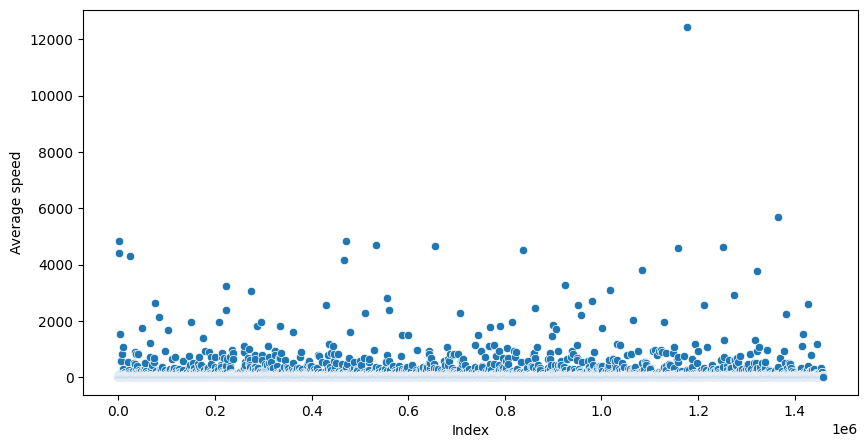

In [44]:
avg_speed = taxi_data['total_distance'] / taxi_data['trip_duration'] * 3.6
fig, ax = plt.subplots(figsize=(10, 5))
sns.scatterplot(x=avg_speed.index, y=avg_speed, ax=ax)
ax.set_xlabel('Index')
ax.set_ylabel('Average speed');

Как раз отсюда мы видим, что у нас есть “поездки-телепортации”, для которых средняя скорость более 1000 км/ч. Даже есть такая, средняя скорость которой составляла более 12000 км/ч!

Давайте условимся, что предельная средняя скорость, которую могут развивать таксисты будет 300 км/ч.


### Задание 2.11.
Найдите поездки, длительность которых превышает 24 часа. И удалите их из набора данных.

а) Сколько выбросов по признаку длительности поездки вам удалось найти?

Найдите поездки, средняя скорость которых по кратчайшему пути превышает 300 км/ч и удалите их из данных.

б) Сколько выбросов по признаку скорости вам удалось найти?

In [45]:
outliers_trip_duration = taxi_data[taxi_data['trip_duration'] > 24*60*60].copy()
taxi_data = taxi_data[taxi_data['trip_duration'] <= 24*60*60]
print(f"Выбросы по признаку длительности поездки составляют {outliers_trip_duration.shape[0]}.")

taxi_data.loc[:, 'avr_speed'] = taxi_data['total_distance'] / taxi_data['trip_duration'] * 3.6
outliers_speed = taxi_data[taxi_data['avr_speed'] > 300].copy()
taxi_data = taxi_data[taxi_data['avr_speed'] <= 300]
taxi_data = taxi_data.drop(columns=['avr_speed'], axis=1)
print(f"Выбросы по признаку скорости составляют {outliers_speed.shape[0]}.")

Выбросы по признаку длительности поездки составляют 4.


<ipython-input-45-7bbf34c53d8b>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  taxi_data.loc[:, 'avr_speed'] = taxi_data['total_distance'] / taxi_data['trip_duration'] * 3.6


Выбросы по признаку скорости составляют 407.


## 3. Разведывательный анализ данных (EDA)

В этой части нашего проекта мы с вами:
* Исследуем сформированный набор данных;
* Попробуем найти закономерности, позволяющие сформулировать предварительные гипотезы относительно того, какие факторы являются решающими в определении длительности поездки;
* Дополним наш анализ визуализациями, иллюстрирующими; исследование. Постарайтесь оформлять диаграммы с душой, а не «для галочки»: навыки визуализации полученных выводов обязательно пригодятся вам в будущем.


Начинаем с целевого признака. Забегая вперед, скажем, что основной метрикой качества решения поставленной задачи будет RMSLE - Root Mean Squared Log Error, которая вычисляется на основе целевой переменной в логарифмическом масштабе. В таком случае целесообразно сразу логарифмировать признак длительности поездки и рассматривать при анализе логарифм в качестве целевого признака:
$$trip\_duration\_log = log(trip\_duration+1),$$
где под символом log подразумевается натуральный логарифм.


In [46]:
taxi_data['trip_duration_log'] = np.log(taxi_data['trip_duration']+1)

### Задание 3.1.
Постройте гистограмму и коробчатую диаграмму длительности поездок в логарифмическом масштабе (trip_duration_log).
Исходя из визуализации, сделайте предположение, является ли полученное распределение нормальным?
Проверьте свою гипотезу с помощью теста Д’Агостино при уровне значимости $\alpha=0.05$.

а) Чему равен вычисленный p-value? Ответ округлите до сотых.

б) Является ли распределение длительности поездок в логарифмическом масштабе нормальным?

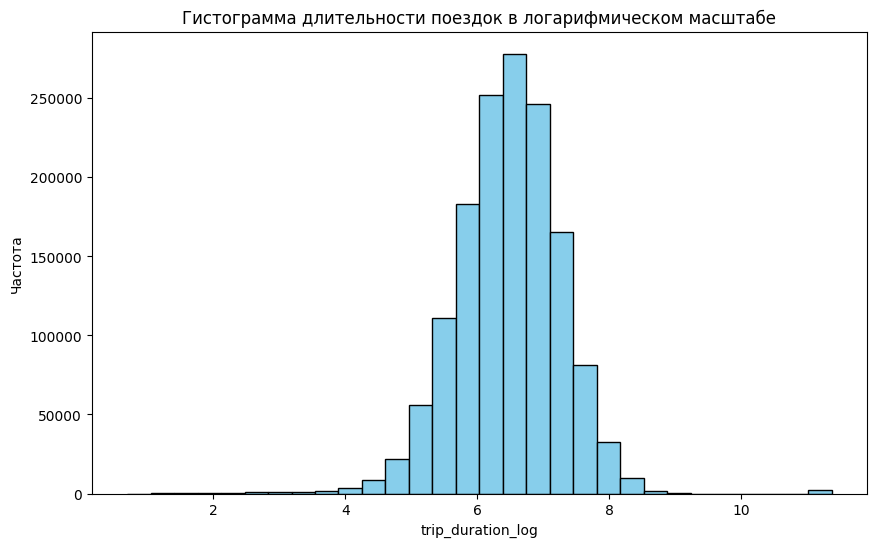

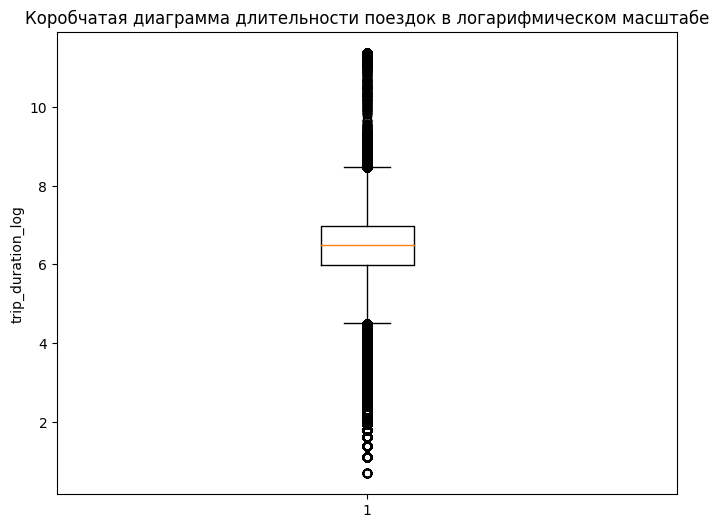

In [47]:
# Построение гистограммы
plt.figure(figsize=(10, 6))
plt.hist(taxi_data['trip_duration_log'], bins=30, color='skyblue', edgecolor='black')
plt.title('Гистограмма длительности поездок в логарифмическом масштабе')
plt.xlabel('trip_duration_log')
plt.ylabel('Частота')
plt.show()

# Построение коробчатой диаграммы
plt.figure(figsize=(8, 6))
plt.boxplot(taxi_data['trip_duration_log'])
plt.title('Коробчатая диаграмма длительности поездок в логарифмическом масштабе')
plt.ylabel('trip_duration_log')
plt.show()



Исходя из визуализации, можно сделать предположение, что полученное распределение является нормальным.

In [48]:
# Проведение теста Д’Агостино
stat, p = normaltest(taxi_data['trip_duration_log'])
alpha = 0.05
print("p-значение:", p)
if p < alpha:
    print("Распределение не является нормальным")
else:
    print("Распределение является нормальным")


p-значение: 0.0
Распределение не является нормальным


### Задание 3.2.
Постройте визуализацию, которая позволит сравнить распределение длительности поездки в логарифмическом масштабе (trip_duration_log) в зависимости от таксопарка (vendor_id).

Сравните два распределения между собой.

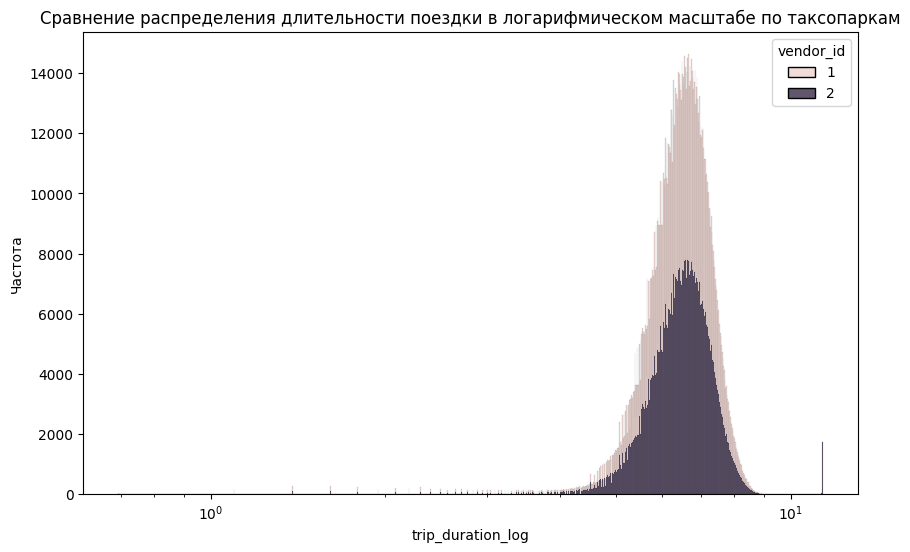

In [49]:
# Построение гистограммы распределения длительности поездки в логарифмическом масштабе по таксопаркам
plt.figure(figsize=(10, 6))
sns.histplot(data=taxi_data, x='trip_duration_log', hue='vendor_id', multiple="stack", log_scale=True)
plt.title('Сравнение распределения длительности поездки в логарифмическом масштабе по таксопаркам')
plt.xlabel('trip_duration_log')
plt.ylabel('Частота')
plt.show()

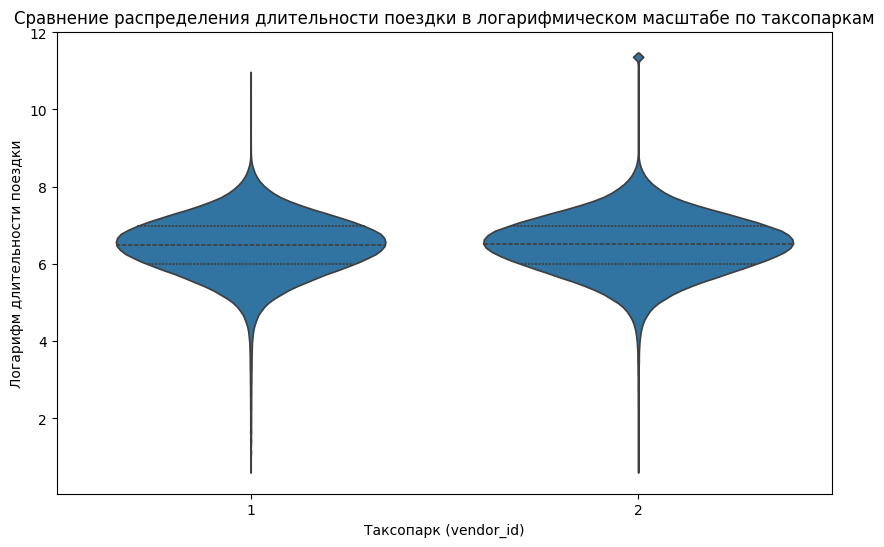

In [50]:
# Построение скрипичной диаграммы распределения длительности поездки в логарифмическом масштабе по таксопаркам
plt.figure(figsize=(10, 6))
sns.violinplot(data=taxi_data, x='vendor_id', y='trip_duration_log', density_norm='count', inner='quartile')
plt.title('Сравнение распределения длительности поездки в логарифмическом масштабе по таксопаркам')
plt.xlabel('Таксопарк (vendor_id)')
plt.ylabel('Логарифм длительности поездки')
plt.show()

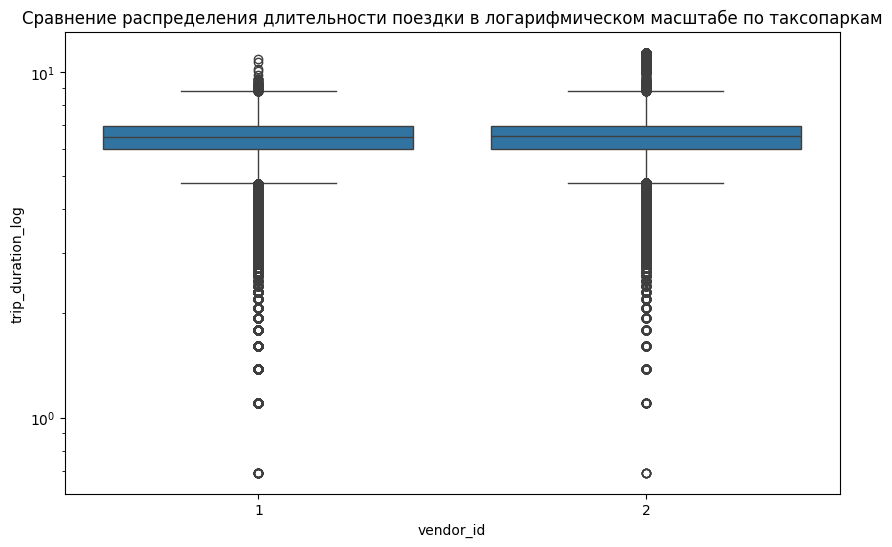

In [51]:
# Построение ящика с усами распределения длительности поездки в логарифмическом масштабе по таксопаркам
plt.figure(figsize=(10, 6))
sns.boxplot(data=taxi_data, x='vendor_id', y='trip_duration_log', log_scale=True)
plt.title('Сравнение распределения длительности поездки в логарифмическом масштабе по таксопаркам')
plt.xlabel('vendor_id')
plt.ylabel('trip_duration_log')
plt.show()

Распределения в группах практически не отличаются, признак vendor_id не имеет значения при определении длительности поездки.

### Задание 3.3.
Постройте визуализацию, которая позволит сравнить распределение длительности поездки в логарифмическом масштабе (trip_duration_log) в зависимости от признака отправки сообщения поставщику (store_and_fwd_flag).

Сравните два распределения между собой.

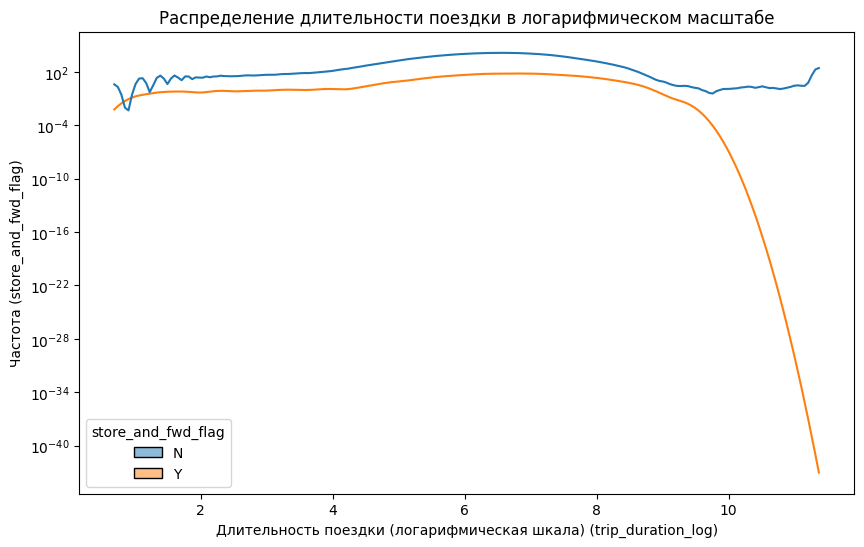

In [52]:
# Построение гистограммы распределения длительности поездки в логарифмическом масштабе в зависимости от store_and_fwd_flag
plt.figure(figsize=(10, 6))
sns.histplot(data=taxi_data, x='trip_duration_log', hue='store_and_fwd_flag', log_scale=(False, True), multiple='dodge', kde=True)
plt.title('Распределение длительности поездки в логарифмическом масштабе')
plt.xlabel('Длительность поездки (логарифмическая шкала) (trip_duration_log)')
plt.ylabel('Частота (store_and_fwd_flag)')
plt.show()

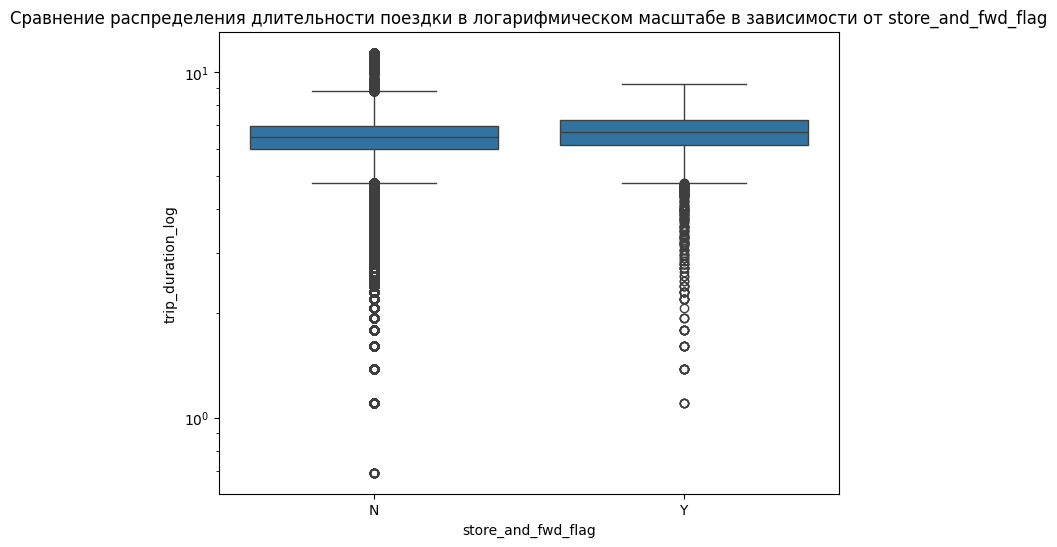

In [53]:
# Построение ящика с усами распределения длительности поездки в логарифмическом масштабе в зависимости от store_and_fwd_flag
plt.figure(figsize=(8, 6))
sns.boxplot(data=taxi_data, x='store_and_fwd_flag', y='trip_duration_log', log_scale=True)
plt.title('Сравнение распределения длительности поездки в логарифмическом масштабе в зависимости от store_and_fwd_flag')
plt.xlabel('store_and_fwd_flag')
plt.ylabel('trip_duration_log')
plt.show()

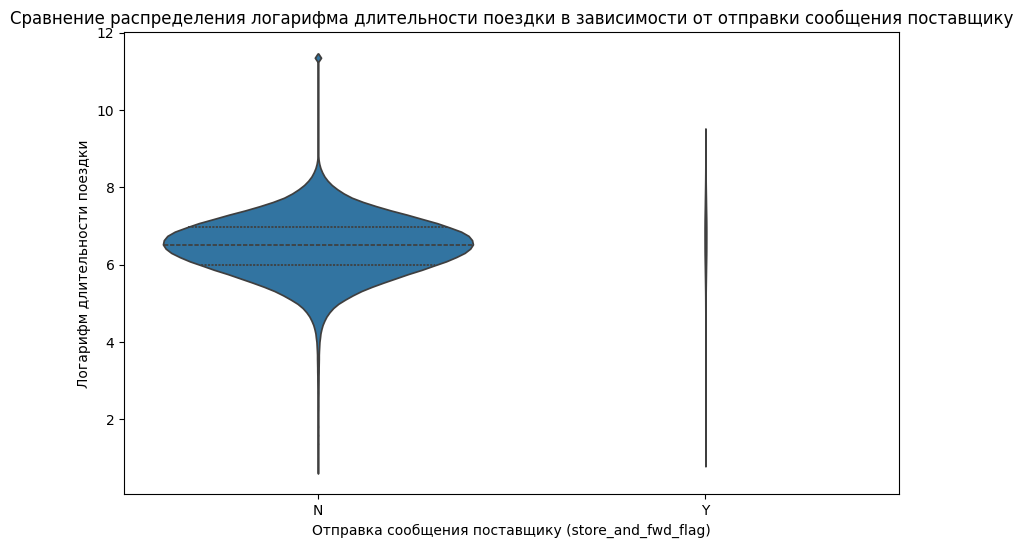

In [54]:
# Построение скрипичной диаграммы распределения длительности поездки в логарифмическом масштабе в зависимости от store_and_fwd_flag
plt.figure(figsize=(10, 6))
sns.violinplot(data=taxi_data, x='store_and_fwd_flag', y='trip_duration_log', density_norm='count', inner='quartile')
plt.title('Сравнение распределения логарифма длительности поездки в зависимости от отправки сообщения поставщику')
plt.xlabel('Отправка сообщения поставщику (store_and_fwd_flag)')
plt.ylabel('Логарифм длительности поездки')
plt.show()

Распределения в группах значительно отличаются, признак store_and_fwd_flag имеет значение при определении длительности поездки.

In [55]:
taxi_data['store_and_fwd_flag'].value_counts()

store_and_fwd_flag
N    1450192
Y       8041
Name: count, dtype: int64

### Задание 3.4.
Постройте две визуализации:
* Распределение количества поездок в зависимости от часа дня;
* Зависимость медианной длительности поездки от часа дня.

На основе построенных графиков ответьте на следующие вопросы:

а) В какое время суток такси заказывают реже всего?

б) В какое время суток наблюдается пик медианной длительности поездок?

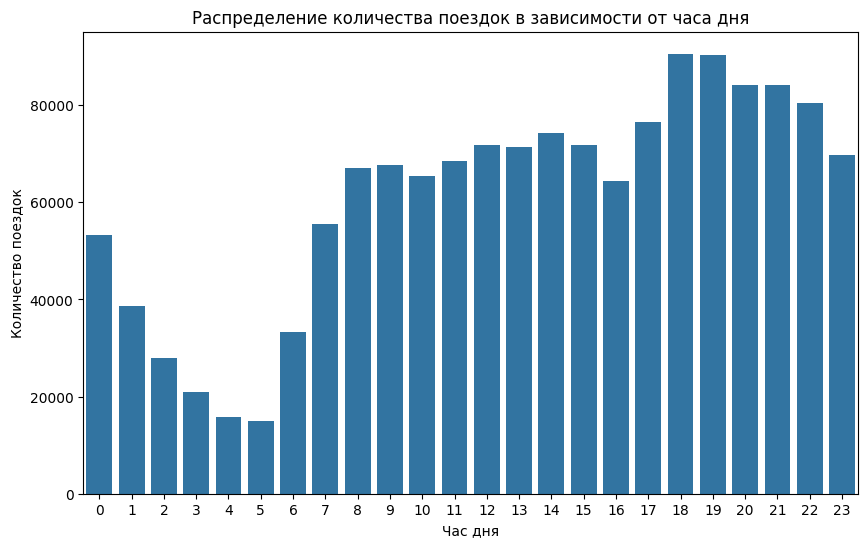

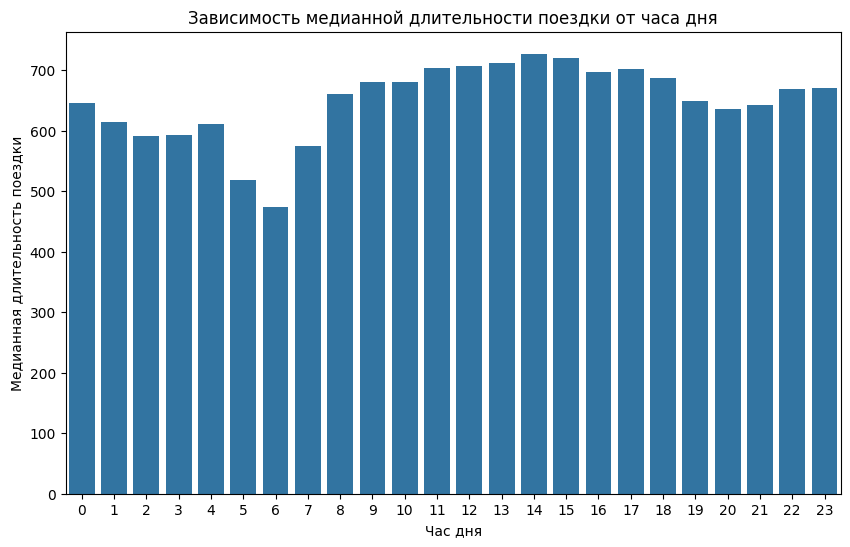

In [56]:
# Построение распределения количества поездок в зависимости от часа дня
plt.figure(figsize=(10, 6))
sns.countplot(data=taxi_data, x='pickup_hour')
plt.title('Распределение количества поездок в зависимости от часа дня')
plt.xlabel('Час дня')
plt.ylabel('Количество поездок')
plt.show()

# Вычисление медианной длительности поездок
trip_duration_median = taxi_data.groupby('pickup_hour')['trip_duration'].median()

# Заполнение столбца с медианными значениями
taxi_data_med = taxi_data['pickup_hour'].to_frame()
taxi_data_med['trip_duration_median'] = taxi_data['pickup_hour'].map(trip_duration_median)

# Построение зависимости медианной длительности поездки от часа дня
plt.figure(figsize=(10, 6))
sns.barplot(data=taxi_data_med, x='pickup_hour', y='trip_duration_median')
plt.title('Зависимость медианной длительности поездки от часа дня')
plt.xlabel('Час дня')
plt.ylabel('Медианная длительность поездки')
plt.show()

С 00:00 по 5:00 такси заказывают реже всего.

С 13:00 по 18:00 наблюдается пик медианной длительности поездок.

### Задание 3.5.
Постройте две визуализации:
* Распределение количества поездок в зависимости от дня недели;
*  Зависимость медианной длительности поездки от дня недели.

На основе построенных графиков ответьте на следующие вопросы:
а) В какой день недели совершается больше всего поездок?
б) В какой день недели медианная длительность поездок наименьшая?


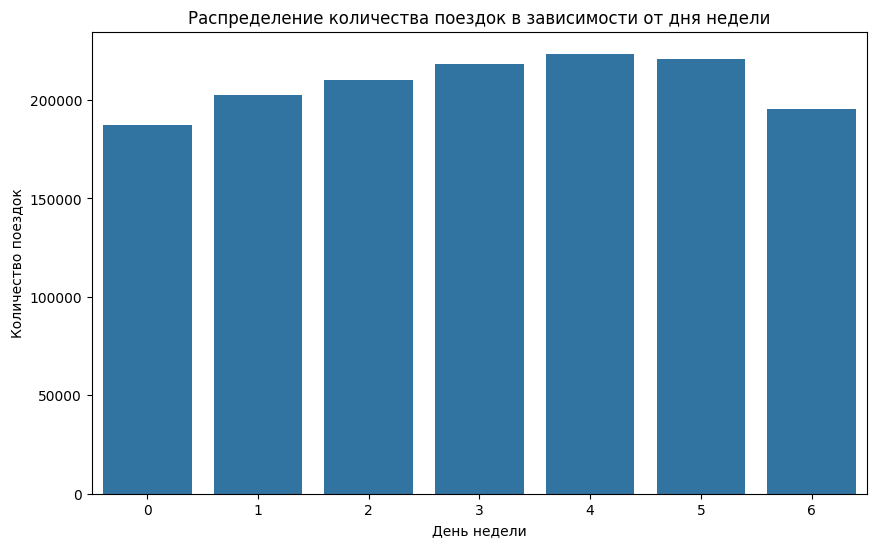

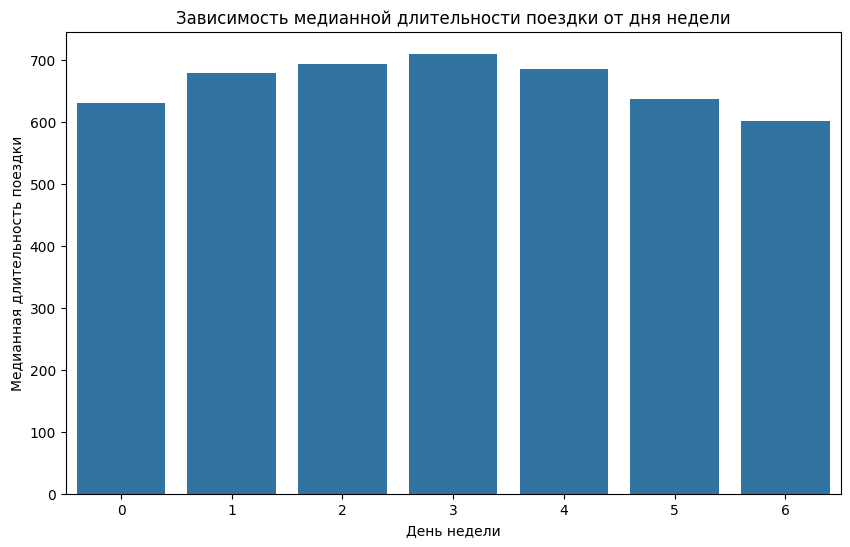

In [57]:
# Построение распределения количества поездок в зависимости от дня недели
plt.figure(figsize=(10, 6))
sns.countplot(data=taxi_data, x='pickup_day_of_week')
plt.title('Распределение количества поездок в зависимости от дня недели')
plt.xlabel('День недели')
plt.ylabel('Количество поездок')
plt.show()

# Вычисление медианной длительности поездок
trip_duration_median_dow = taxi_data.groupby('pickup_day_of_week')['trip_duration'].median()

# Заполнение столбца с медианными значениями
taxi_data_med['pickup_day_of_week'] = taxi_data['pickup_day_of_week']
taxi_data_med['trip_duration_median_day_of_week'] = taxi_data['pickup_day_of_week'].map(trip_duration_median_dow)

# Построение зависимости медианной длительности поездки от дня недели
plt.figure(figsize=(10, 6))
sns.barplot(data=taxi_data_med, x='pickup_day_of_week', y='trip_duration_median_day_of_week')
plt.title('Зависимость медианной длительности поездки от дня недели')
plt.xlabel('День недели')
plt.ylabel('Медианная длительность поездки')
plt.show()

В пятницу совершается больше всего поездок.

В воскресенье медианная длительность поездок наименьшая.

### Задание 3.6.
Посмотрим на обе временные характеристики одновременно.

Постройте сводную таблицу, по строкам которой отложены часы (pickup_hour), по столбцам - дни недели (pickup_day_of_week), а в ячейках - медианная длительность поездки (trip_duration).

Визуализируйте полученную сводную таблицу с помощью тепловой карты (рекомендуемая палитра - coolwarm).

In [58]:
pivot_table = pd.pivot_table(taxi_data, values='trip_duration', index='pickup_hour', columns='pickup_day_of_week', aggfunc='median')
pivot_table

pickup_day_of_week,0,1,2,3,4,5,6
pickup_hour,,,,,,,
0,598.0,591.0,601.0,609.0,649.0,685.0,675.0
1,567.0,584.0,553.0,564.0,600.0,640.0,643.0
2,565.0,565.0,544.0,576.0,572.0,610.0,604.5
3,600.0,568.0,574.0,584.0,578.0,591.0,608.0
4,640.0,600.5,616.0,595.0,634.0,610.0,598.5
5,519.0,455.0,448.0,480.0,532.0,631.0,634.0
6,462.0,461.0,463.0,471.0,476.0,508.0,554.0
7,575.0,586.0,593.0,599.0,578.0,481.0,474.0
8,672.0,703.0,704.0,721.0,689.0,489.0,460.0


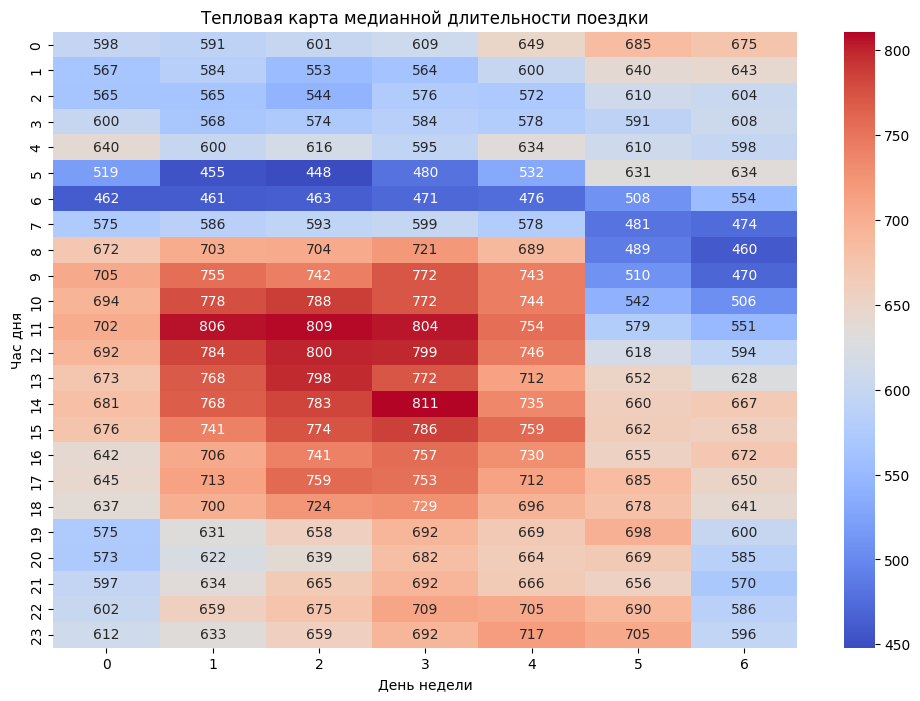

In [59]:
# Создание тепловой карты
plt.figure(figsize=(12, 8))
sns.heatmap(pivot_table, cmap='coolwarm', annot=True, fmt=".0f")
plt.title('Тепловая карта медианной длительности поездки')
plt.xlabel('День недели')
plt.ylabel('Час дня')
plt.show()

Самые продолжительные поездки (в медианном смысле) наблюдаются с понедельника по пятницу в промежутке с 8 до 18 часов.

Наибольшая медианная длительность поездки наблюдалась в четверг в 14 часов дня.

### Задание 3.7.
Постройте две диаграммы рассеяния (scatter-диаграммы):
* первая должна иллюстрировать географическое расположение точек начала поездок (pickup_longitude, pickup_latitude)
* вторая должна географическое расположение точек завершения поездок (dropoff_longitude, dropoff_latitude).

Для этого на диаграммах по оси абсцисс отложите широту (longitude), а по оси ординат - долготу (latitude).
Включите в визуализацию только те точки, которые находятся в пределах Нью-Йорка - добавьте следующие ограничения на границы осей абсцисс и ординат:

city_long_border = (-74.03, -73.75)

city_lat_border = (40.63, 40.85)

Добавьте на диаграммы расцветку по десяти географическим кластерам (geo_cluster), которые мы сгенерировали ранее.

**Рекомендация:** для наглядности уменьшите размер точек на диаграмме рассеяния.  


/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


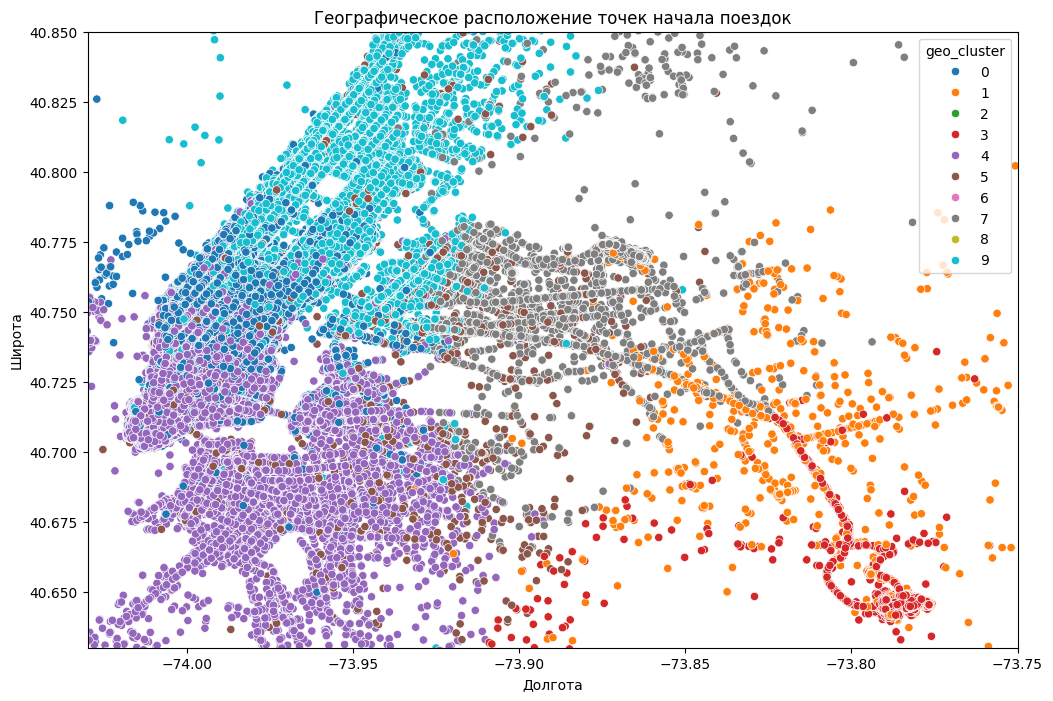

/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


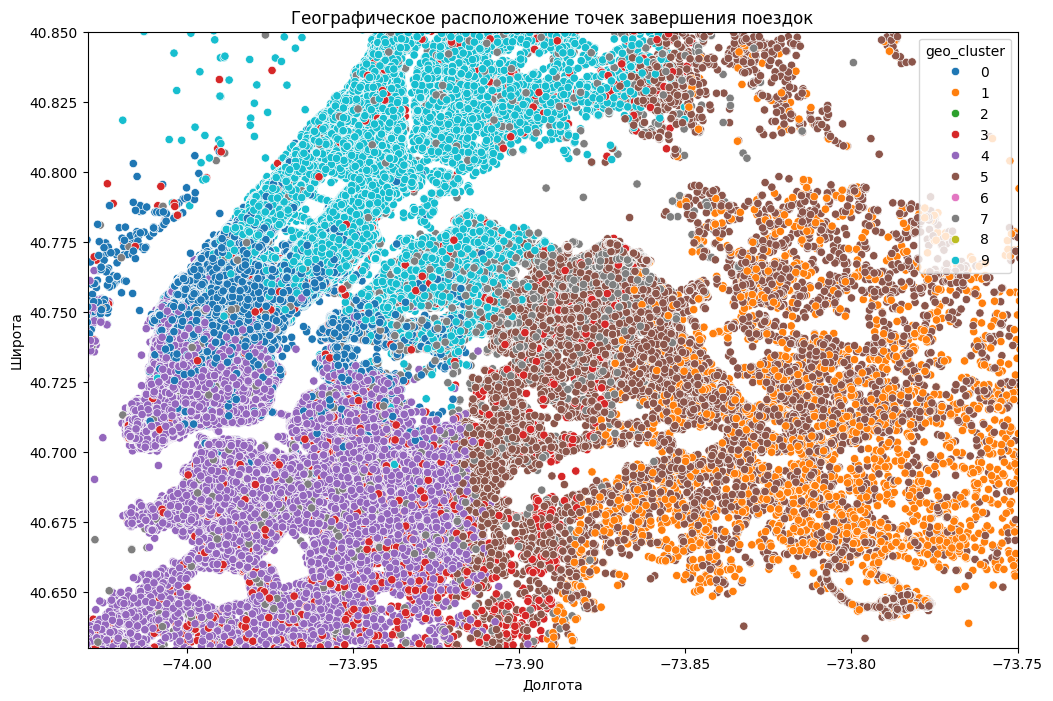

In [60]:
# Ограничения на границы осей абсцисс и ординат
city_long_border = (-74.03, -73.75)
city_lat_border = (40.63, 40.85)

# Создание диаграммы рассеяния для точек начала поездок
plt.figure(figsize=(12, 8))
sns.scatterplot(x='pickup_longitude', y='pickup_latitude', hue='geo_cluster', data=taxi_data, palette='tab10')
plt.xlim(city_long_border)
plt.ylim(city_lat_border)
plt.title('Географическое расположение точек начала поездок')
plt.xlabel('Долгота')
plt.ylabel('Широта')
plt.show()

# Создание диаграммы рассеяния для точек завершения поездок
plt.figure(figsize=(12, 8))
sns.scatterplot(x='dropoff_longitude', y='dropoff_latitude', hue='geo_cluster', data=taxi_data, palette='tab10')
plt.xlim(city_long_border)
plt.ylim(city_lat_border)
plt.title('Географическое расположение точек завершения поездок')
plt.xlabel('Долгота')
plt.ylabel('Широта')
plt.show()


## 4. Отбор и преобразование признаков

Перед тем как перейти к построению модели, осталось сделать ещё несколько шагов.
* Следует помнить, что многие алгоритмы машинного обучения не могут обрабатывать категориальные признаки в их обычном виде. Поэтому нам необходимо их закодировать;
* Надо отобрать признаки, которые мы будем использовать для обучения модели;
*  Необходимо масштабировать и трансформировать некоторые признаки для того, чтобы улучшить сходимость моделей, в основе которых лежат численные методы.


In [66]:
print('Shape of data: {}'.format(taxi_data.shape))
print('Columns: {}'.format(taxi_data.columns))

Shape of data: (1458233, 27)
Columns: Index(['id', 'vendor_id', 'pickup_datetime', 'dropoff_datetime',
       'passenger_count', 'pickup_longitude', 'pickup_latitude',
       'dropoff_longitude', 'dropoff_latitude', 'store_and_fwd_flag',
       'trip_duration', 'pickup_date', 'pickup_hour', 'pickup_day_of_week',
       'pickup_holiday', 'total_distance', 'total_travel_time',
       'number_of_steps', 'haversine_distance', 'direction', 'geo_cluster',
       'temperature', 'visibility', 'wind speed', 'precip', 'events',
       'trip_duration_log'],
      dtype='object')


Для удобства работы сделаем копию исходной таблицы с поездками:

In [67]:
train_data = taxi_data.copy()
train_data.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,...,number_of_steps,haversine_distance,direction,geo_cluster,temperature,visibility,wind speed,precip,events,trip_duration_log
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,...,5.0,1.498521,99.970196,9,4.4,8.0,27.8,0.3,None,6.122493
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,...,6.0,1.805507,-117.153768,4,28.9,16.1,7.4,0.0,None,6.498282
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,...,16.0,6.385098,-159.680165,4,-6.7,16.1,24.1,0.0,None,7.661527
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,...,4.0,1.485498,-172.737700,4,7.2,16.1,25.9,0.0,None,6.063785
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,...,5.0,1.188588,179.473585,9,9.4,16.1,9.3,0.0,None,6.077642


### Задание 4.1.
Сразу позаботимся об очевидных неинформативных и избыточных признаках.

а) Какой из признаков является уникальным для каждой поездки и не несет полезной информации в определении ее продолжительности?

б) Утечка данных (data leak) - это…

в) Подумайте, наличие какого из признаков в обучающем наборе данных создает утечку данных?

г) Исключите выбранные в пунктах а) и в) признаки из исходной таблицы с данными. Сколько столбцов в таблице у вас осталось?


Наличие признака "dropoff_datetime" в обучающем наборе данных может создать утечку данных. Это потому, что информация о времени высадки пассажиров может быть связана с целевой переменной, и использование этого признака в модели может привести к переобучению, поскольку в реальных условиях временные данные о высадке пассажиров будут недоступны в момент прогнозирования.

In [68]:
drop_columns = ['id', 'dropoff_datetime']
train_data = train_data.drop(drop_columns, axis=1)
print(f'Осталось:  {train_data.shape[1]} признаков')

Осталось:  25 признаков


Ранее мы извлекли всю необходимую для нас информацию из даты начала поездки, теперь мы можем избавиться от этих признаков, так как они нам больше не понадобятся:


In [69]:
drop_columns = ['pickup_datetime', 'pickup_date']
train_data = train_data.drop(drop_columns, axis=1)
print('Shape of data:  {}'.format(train_data.shape))

Shape of data:  (1458233, 23)


### Задание 4.2.

Закодируйте признак vendor_id в таблице train_data таким образом, чтобы он был равен 0, если идентификатор таксопарка равен 1, и 1 — в противном случае.

Закодируйте признак store_and_fwd_flag в таблице train_data таким образом, чтобы он был равен 0, если флаг выставлен в значение 'N', и 1 — в противном случае.

а) Рассчитайте среднее по закодированному столбцу vendor_id. Ответ приведите с точностью до сотых.

б) Рассчитайте среднее по закодированному столбцу store_and_fwd_flag. Ответ приведите с точностью до тысячных.



In [70]:
# Закодировать признак vendor_id
train_data['vendor_id'] = (train_data['vendor_id'] != 1).astype(int)

# Закодировать признак store_and_fwd_flag
train_data['store_and_fwd_flag'] = (train_data['store_and_fwd_flag'] != 'N').astype(int)

# Рассчет среднего по закодированному столбцу vendor_id
avr_vendor_id = round(train_data['vendor_id'].mean(), 2)

# Рассчет среднего по закодированному столбцу store_and_fwd_flag
avr_store_and_fwd_flag = round(train_data['store_and_fwd_flag'].mean(), 3)

print("Среднее по закодированному столбцу vendor_id", avr_vendor_id)
print("Среднее по закодированному столбцу store_and_fwd_flag", avr_store_and_fwd_flag)

Среднее по закодированному столбцу vendor_id 0.53
Среднее по закодированному столбцу store_and_fwd_flag 0.006


### Задание 4.3.
Создайте таблицу data_onehot из закодированных однократным кодированием признаков pickup_day_of_week, geo_cluster и events в таблице train_data с помощью OneHotEncoder из библиотеки sklearn. Параметр drop выставите в значение 'first', чтобы удалять первый бинарный столбец, тем самым не создавая излишних признаков.

В параметре handle_unknown установите значение 'ignore'. Это позволит коду отработать без ошибок в случае появления в тестовой выборке значений, отсутствующих в обучающей выборке.

В результате работы OneHotEncoder вы получите безымянный numpy-массив, который нам будет необходимо преобразовать обратно в DataFrame, для более удобной работы в дальнейшем. Чтобы получить имена закодированных столбцов у объекта типа OneHotEncoder есть специальный метод get_feature_names_out(). Он возвращает список новых закодированных имен столбцов в формате <оригинальное имя столбца>_<имя категории>.

Пример использования:

``` python
# Объявляем кодировщик
one_hot_encoder = OneHotEncoder(drop='first', handle_unknown='ignore')
# Получаем закодированные имена столбцов
column_names = one_hot_encoder.get_feature_names_out()
# Составляем DataFrame из закодированных признаков
data_onehot = pd.DataFrame(data_onehot, columns=column_names)
```

В этом псевдокоде:
* one_hot_encoder - объект класса OneHotEncoder
* data_onehot - numpy-массив, полученный в результате трансформации кодировщиком

В результате выполнения задания у вас должен быть образован DataFrame `data_onehot`, который содержит кодированные категориальные признаки pickup_day_of_week, geo_cluster и events.


Сколько бинарных столбцов у вас получилось сгенерировать с помощью однократного кодирования?


In [71]:
# Выбор признаков для кодирования
features_to_encode = train_data[['pickup_day_of_week', 'geo_cluster', 'events']]

# Создание экземпляра OneHotEncoder с указанными параметрами
one_hot_encoder = OneHotEncoder(drop='first', handle_unknown='ignore')

# Применение кодировщика к выбранным признакам и преобразование в DataFrame
data_onehot = pd.DataFrame(one_hot_encoder.fit_transform(features_to_encode).toarray(), columns=one_hot_encoder.get_feature_names_out(features_to_encode.columns))

In [72]:
print("Количество сгенерированных с помощью OneHotEncoding столбцов:", data_onehot.shape[1])

Количество сгенерированных с помощью OneHotEncoding столбцов: 18


Добавим полученную таблицу с закодированными признаками:

In [73]:
train_data = pd.concat(
    [train_data.reset_index(drop=True).drop(features_to_encode, axis=1), data_onehot],
    axis=1
)
print(f"Shape of data: {train_data.shape}")

Shape of data: (1458233, 38)


Теперь, когда категориальные признаки предобработаны, сформируем матрицу наблюдений X, вектор целевой переменной y и его логарифм y_log. В матрицу наблюдений войдут все столбцы из таблицы с поездками за исключением целевого признака trip_duration и его логарифмированной версии trip_duration_log:


In [74]:
X = train_data.drop(['trip_duration', 'trip_duration_log'], axis=1)
y = train_data['trip_duration']
y_log = train_data['trip_duration_log']

Все наши модели мы будем обучать на логарифмированной версии y_log.

Выбранный тип валидации - hold-out. Разобьем выборку на обучающую и валидационную в соотношении 67/33:

In [75]:
X_train, X_valid, y_train_log, y_valid_log = model_selection.train_test_split(
    X, y_log,
    test_size=0.33,
    random_state=42
)

На данный момент у нас достаточно много признаков: скорее всего, не все из них будут важны. Давайте оставим лишь те, которые сильнее всего связаны с целевой переменной и точно будут вносить вклад в повышение качества модели.


### Задание 4.4.
С помощью SelectKBest отберите 25 признаков, наилучшим образом подходящих для предсказания целевой переменной в логарифмическом масштабе. Отбор реализуйте по обучающей выборке, используя параметр score_func = f_regression.

Укажите признаки, которые вошли в список отобранных


In [76]:
# Создание экземпляра SelectKBest с параметром score_func=f_regression
selector = SelectKBest(score_func=f_regression, k=25)

# Применение SelectKBest к обучающей выборке
X_train_selected = selector.fit_transform(X_train, y_train_log)

# Оставление только отобранных признаков в обучающей и валидационной выборках
X_train_selected_columns = X_train.columns[selector.get_support()]
X_train_selected = X_train[X_train_selected_columns]
X_valid_selected = X_valid[X_train_selected_columns]

In [77]:
X_train_selected_columns

Index(['vendor_id', 'passenger_count', 'pickup_longitude', 'pickup_latitude',
       'dropoff_longitude', 'dropoff_latitude', 'store_and_fwd_flag',
       'pickup_hour', 'pickup_holiday', 'total_distance', 'total_travel_time',
       'number_of_steps', 'haversine_distance', 'temperature',
       'pickup_day_of_week_1', 'pickup_day_of_week_2', 'pickup_day_of_week_3',
       'pickup_day_of_week_4', 'pickup_day_of_week_5', 'pickup_day_of_week_6',
       'geo_cluster_1', 'geo_cluster_3', 'geo_cluster_5', 'geo_cluster_7',
       'geo_cluster_9'],
      dtype='object')

Так как мы будем использовать различные модели, в том числе внутри которых заложены численные методы оптимизации, то давайте заранее позаботимся о масштабировании факторов.


### Задание 4.5.
Нормализуйте предикторы в обучающей и валидационной выборках с помощью MinMaxScaler из библиотеки sklearn. Помните, что обучение нормализатора производится на обучающей выборке, а трансформация на обучающей и валидационной!

Рассчитайте среднее арифметическое для первого предиктора (т. е. для первого столбца матрицы) из валидационной выборки. Ответ округлите до сотых.


In [78]:
# Создание экземпляра MinMaxScaler
scaler = MinMaxScaler()

# Обучение нормализатора на обучающей выборке и трансформация обучающей и валидационной выборок
X_train_selected_normalized = scaler.fit_transform(X_train_selected)
X_valid_selected_normalized = scaler.transform(X_valid_selected)

# Рассчет среднего арифметического для первого предиктора
mean_first_predictor = round(np.mean(X_valid_selected_normalized[:, 0]), 2)
mean_first_predictor

0.54

In [79]:
# Сохранение DataFrame в CSV
X_train_selected_normalized_df = pd.DataFrame(data=X_train_selected_normalized, columns=X_train_selected_columns)
X_valid_selected_normalized_df = pd.DataFrame(data=X_valid_selected_normalized, columns=X_train_selected_columns)
# X_train_selected_normalized_df.to_csv('/content/drive/MyDrive/ProjectPracticum2/X_train_selected_normalized.csv', index=False)
# X_valid_selected_normalized_df.to_csv('/content/drive/MyDrive/ProjectPracticum2/X_valid_selected_normalized.csv', index=False)

y_train_log_df = pd.DataFrame(data=y_train_log)
y_valid_log_df = pd.DataFrame(data=y_valid_log)
# y_train_log_df.to_csv('/content/drive/MyDrive/ProjectPracticum2/y_train_log.csv', index=False)
# y_valid_log_df.to_csv('/content/drive/MyDrive/ProjectPracticum2/y_valid_log.csv', index=False)

## 5. Решение задачи регрессии: линейная регрессия и деревья решений

Определим метрику, по которой мы будем измерять качество наших моделей. Мы будем следовать канонам исходного соревнования на Kaggle и в качестве метрики использовать RMSLE (Root Mean Squared Log Error), которая вычисляется как:
$$RMSLE = \sqrt{\frac{1}{n}\sum_{i=1}^n(log(y_i+1)-log(\hat{y_i}+1))^2},$$
где:
* $y_i$ - истинная длительность i-ой поездки на такси (trip_duration)
* $\hat{y_i}$- предсказанная моделью длительность i-ой поездки на такси

Заметим, что логарифмирование целевого признака мы уже провели заранее, поэтому нам будет достаточно вычислить метрику RMSE для модели, обученной прогнозировать длительность поездки такси в логарифмическом масштабе:
$$z_i=log(y_i+1),$$
$$RMSLE = \sqrt{\frac{1}{n}\sum_{i=1}^n(z_i-\hat{z_i})^2}=\sqrt{MSE(z_i,\hat{z_i})}$$



### Задание 5.1.
Постройте модель линейной регрессии на обучающей выборке (факторы должны быть нормализованы, целевую переменную используйте в логарифмическом масштабе). Все параметры оставьте по умолчанию.

Для полученной модели рассчитайте метрику RMSLE на тренировочной и валидационной выборках. Ответ округлите до сотых.


In [84]:
X_train_selected_normalized_df = pd.read_csv('/content/drive/MyDrive/ProjectPracticum2/X_train_selected_normalized.csv')
X_valid_selected_normalized_df = pd.read_csv('/content/drive/MyDrive/ProjectPracticum2/X_valid_selected_normalized.csv')

y_train_log_df = pd.read_csv('/content/drive/MyDrive/ProjectPracticum2/y_train_log.csv')
y_valid_log_df = pd.read_csv('/content/drive/MyDrive/ProjectPracticum2/y_valid_log.csv')

In [85]:
# Строим модель линейной регрессии
model = LinearRegression()

# Обучаем модель
model.fit(X_train_selected_normalized, y_train_log)

# Рассчитываем метрику RMSLE на тренировочной выборке
y_train_pred_log = model.predict(X_train_selected_normalized)
rmsle_train = np.sqrt(np.mean((y_train_log - y_train_pred_log)**2))

# Рассчитываем метрику RMSLE на валидационной выборке
y_val_pred_log = model.predict(X_valid_selected_normalized)
rmsle_valid = np.sqrt(np.mean((y_valid_log - y_val_pred_log)**2))

# Выводим результаты
print("RMSLE на тренировочной выборке:", round(rmsle_train, 2))
print("RMSLE на валидационной выборке:", round(rmsle_valid, 2))


RMSLE на тренировочной выборке: 0.54
RMSLE на валидационной выборке: 0.54


### Задание 5.2.
Сгенерируйте полиномиальные признаки 2-ой степени с помощью PolynomialFeatures из библиотеки sklearn. Параметр include_bias выставите в значение False.

Постройте модель полиномиальной регрессии 2-ой степени на обучающей выборке (факторы должны быть нормализованы, целевую переменную используйте в логарифмическом масштабе). Все параметры оставьте по умолчанию.

а) Для полученной модели рассчитайте метрику RMSLE на тренировочной и валидационной выборках. Ответ округлите до сотых.

б) Наблюдаются ли у вашей модели признаки переобучения?


In [86]:
# # Создаем объект PolynomialFeatures для генерации полиномиальных признаков второй степени без добавления bias
# poly = PolynomialFeatures(degree=2, include_bias=False)

# # Генерируем полиномиальные признаки
# X_train_poly = poly.fit_transform(X_train_selected_normalized)

# # Строим модель линейной регрессии
# model_poly = LinearRegression()

# # Обучаем модель
# model_poly.fit(X_train_poly, y_train_log)

# # Рассчитываем метрику RMSLE на тренировочной выборке
# y_train_pred_log = model_poly.predict(X_train_poly)
# rmsle_train_poly = np.sqrt(np.mean((y_train_log - y_train_pred_log)**2))

# # Нормализуем факторы в валидационной выборке
# X_val_poly = poly.transform(X_valid_selected_normalized)

# # Рассчитываем метрику RMSLE на валидационной выборке
# y_val_pred_log = model.predict(X_val_poly)
# rmsle_val_poly = np.sqrt(np.mean((y_valid_log - y_val_pred_log)**2))

# # Выводим результаты
# print("RMSLE на тренировочной выборке:", round(rmsle_train_poly, 2))
# print("RMSLE на валидационной выборке:", round(rmsle_val_poly, 2))

### Задание 5.3.
Постройте модель полиномиальной регрессии 2-ой степени с L2-регуляризацией (регуляризация по Тихонову) на обучающей выборке  (факторы должны быть нормализованы, целевую переменную используйте в логарифмическом масштабе). Коэффициент регуляризации $\alpha$ установите равным 1, остальные параметры оставьте по умолчанию.

Для полученной модели рассчитайте метрику RMSLE на тренировочной и валидационной выборках. Ответ округлите до сотых.


In [87]:
# ваш код здесь

### Задание 5.4.
Постройте модель дерева решений (DecisionTreeRegressor) на обучающей выборке (факторы должны быть нормализованы, целевую переменную используйте в логарифмическом масштабе). Все параметры оставьте по умолчанию.

а) Для полученной модели рассчитайте метрику RMSLE на тренировочной и валидационной выборках. Ответ округлите до сотых.

б) Наблюдаются ли у вашей модели признаки переобучения?


In [88]:
# Строим модель дерева решений
model = DecisionTreeRegressor(random_state = 42)

# Обучаем модель
model.fit(X_train_selected_normalized, y_train_log)

# Рассчитываем метрику RMSLE на тренировочной выборке
y_train_pred_log = model.predict(X_train_selected_normalized)
rmsle_train = np.sqrt(np.mean((y_train_log - y_train_pred_log)**2))

# Рассчитываем метрику RMSLE на валидационной выборке
y_val_pred_log = model.predict(X_valid_selected_normalized)
rmsle_val = np.sqrt(np.mean((y_valid_log - y_val_pred_log)**2))

# Выводим результаты
print("RMSLE на тренировочной выборке:", round(rmsle_train, 2))
print("RMSLE на валидационной выборке:", round(rmsle_val, 2))

RMSLE на тренировочной выборке: 0.0
RMSLE на валидационной выборке: 0.57


### Задание 5.5.
Переберите все возможные варианты глубины дерева решений в диапазоне от 7 до 20:

max_depths = range(7, 20)

Параметр random_state задайте равным 42.

Постройте линейные графики изменения метрики RMSE на тренировочной и валидационной выборках в зависимости от значения параметра глубины дерева решений.

а) Найдите оптимальное значение максимальной глубины дерева, для которой будет наблюдаться минимальное значение RMSLE на обучающей выборке, но при этом еще не будет наблюдаться переобучение (валидационная кривая еще не начинает возрастать).

б) Чему равно значение метрик RMSLE на тренировочной и валидационной выборках для дерева решений с выбранной оптимальной глубиной? Ответ округлите до сотых.


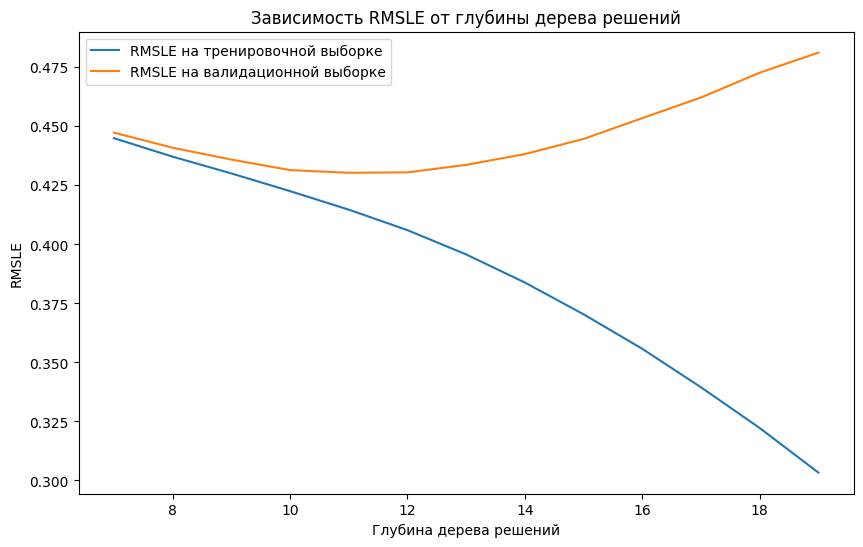

In [89]:
# Задаем диапазон глубины дерева
max_depths = range(7, 20)

# Создаем пустые списки для хранения значений RMSLE
rmsle_train_list = []
rmsle_val_list = []

# Перебираем все возможные варианты глубины дерева
for depth in max_depths:
    # Строим модель дерева решений с указанной глубиной
    model = DecisionTreeRegressor(max_depth=depth, random_state=42)

    # Обучаем модель
    model.fit(X_train_selected_normalized, y_train_log)

    # Рассчитываем метрику RMSLE на тренировочной выборке
    y_train_pred_log = model.predict(X_train_selected_normalized)
    rmsle_train = np.sqrt(np.mean((y_train_log - y_train_pred_log)**2))
    rmsle_train_list.append(rmsle_train)

    # Рассчитываем метрику RMSLE на валидационной выборке
    y_val_pred_log = model.predict(X_valid_selected_normalized)
    rmsle_val = np.sqrt(np.mean((y_valid_log - y_val_pred_log)**2))
    rmsle_val_list.append(rmsle_val)

# Строим графики
plt.figure(figsize=(10, 6))
plt.plot(max_depths, rmsle_train_list, label='RMSLE на тренировочной выборке')
plt.plot(max_depths, rmsle_val_list, label='RMSLE на валидационной выборке')
plt.xlabel('Глубина дерева решений')
plt.ylabel('RMSLE')
plt.title('Зависимость RMSLE от глубины дерева решений')
plt.legend()
plt.show()

In [90]:
# Находим значения метрик RMSLE на тренировочной и валидационной выборках
# для дерева решений с выбранной оптимальной глубиной
optimal_depth = 12
model = DecisionTreeRegressor(max_depth=optimal_depth, random_state=42)

# Обучаем модель
model.fit(X_train_selected_normalized, y_train_log)

# Рассчитываем метрику RMSLE на тренировочной выборке
y_train_pred_log = model.predict(X_train_selected_normalized)
rmsle_train = np.sqrt(np.mean((y_train_log - y_train_pred_log)**2))

# Рассчитываем метрику RMSLE на валидационной выборке
y_val_pred_log = model.predict(X_valid_selected_normalized)
rmsle_val = np.sqrt(np.mean((y_valid_log - y_val_pred_log)**2))

print(f"RMSLE на тренировочной выборке: {round(rmsle_train, 2)}")
print(f"RMSLE на тренировочной выборке: {round(rmsle_val, 2)}")

RMSLE на тренировочной выборке: 0.41
RMSLE на тренировочной выборке: 0.43


## 6. Решение задачи регрессии: ансамблевые методы и построение прогноза

Переходим к тяжелой артиллерии: ансамблевым алгоритмам.

### Задание 6.1.

Постройте модель случайного леса на обучающей выборке (факторы должны быть нормализованы, целевую переменную используйте в логарифмическом масштабе). В качестве гиперпараметров укажите следующие:
* n_estimators=200,
* max_depth=12,
* criterion='squared_error',
* min_samples_split=20,
* random_state=42

Для полученной модели рассчитайте метрику RMSLE на тренировочной и валидационной выборках. Ответ округлите до сотых.


In [4]:
# Создание и обучение модели случайного леса
model = RandomForestRegressor(n_estimators=200, max_depth=12, criterion='squared_error',
                                min_samples_split=20, random_state=42, verbose=True)
model.fit(X_train_selected_normalized_df, y_train_log_df.values.ravel())

# Прогнозирование на обучающей выборке
y_train_pred = model.predict(X_train_selected_normalized_df)
rmsle_train = np.sqrt(np.mean((y_train_log_df.values.ravel() - y_train_pred)**2))

# Прогнозирование на валидационной выборке
y_valid_pred = model.predict(X_valid_selected_normalized_df)
rmsle_valid = np.sqrt(np.mean((y_valid_log_df.values.ravel() - y_valid_pred)**2))

# Вывод результатов
print(f'RMSLE на тренировочной выборке: {rmsle_train:.2f}')
print(f'RMSLE на валидационной выборке: {rmsle_valid:.2f}')

[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed: 11.5min
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed: 45.2min
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    8.5s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:   31.8s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    5.0s


RMSLE на тренировочной выборке: 0.40
RMSLE на валидационной выборке: 0.41


[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:   16.3s


### Задание 6.2.
Постройте модель градиентного бустинга над деревьями решений (GradientBoostingRegressor) на обучающей выборке (факторы должны быть нормализованы, целевую переменную используйте в логарифмическом масштабе). В качестве гиперпараметров укажите следующие:
* learning_rate=0.5,
* n_estimators=100,
* max_depth=6,
* min_samples_split=30,
* random_state=42

Для полученной модели рассчитайте метрику RMSLE на тренировочной и валидационной выборках. Ответ округлите до сотых.


In [9]:
# Создание и обучение модели градиентного бустинга
model = GradientBoostingRegressor(learning_rate=0.5, n_estimators=100, max_depth=6,
                                  min_samples_split=30, random_state=42, verbose=True)
model.fit(X_train_selected_normalized_df, y_train_log_df.values.ravel())

# Прогнозирование на обучающей выборке
y_train_pred = model.predict(X_train_selected_normalized_df)
rmsle_train = np.sqrt(np.mean((y_train_log_df.values.ravel() - y_train_pred)**2))

# Прогнозирование на валидационной выборке
y_valid_pred = model.predict(X_valid_selected_normalized_df)
rmsle_valid = np.sqrt(np.mean((y_valid_log_df.values.ravel() - y_valid_pred)**2))

# Вывод результатов
print(f'RMSLE на тренировочной выборке: {rmsle_train:.2f}')
print(f'RMSLE на валидационной выборке: {rmsle_valid:.2f}')

      Iter       Train Loss   Remaining Time 
         1           0.3110           20.06m
         2           0.2247           30.64m
         3           0.1987           32.94m
         4           0.1876           29.98m
         5           0.1823           27.54m
         6           0.1783           25.82m
         7           0.1756           24.56m
         8           0.1730           23.27m
         9           0.1709           22.40m
        10           0.1696           21.69m
        20           0.1577           17.48m
        30           0.1538           14.58m
        40           0.1502           12.32m
        50           0.1480           10.08m
        60           0.1451            7.98m
        70           0.1431            5.92m
        80           0.1410            3.92m
        90           0.1393            1.95m
       100           0.1383            0.00s
RMSLE на тренировочной выборке: 0.37
RMSLE на валидационной выборке: 0.39


### Задание 6.3.
Какая из построенных вами моделей показала наилучший результат (наименьшее значение RMSLE на валидационной выборке)?
* Линейная регрессия
* Полиномиальная регрессия 2ой степени
* Дерево решений
* Случайный лес
* Градиентный бустинг над деревьями решений


### Задание 6.4.
Постройте столбчатую диаграмму коэффициентов значимости каждого из факторов.

Укажите топ-3 наиболее значимых для предсказания целевого признака - длительности поездки в логарифмическом масштабе - факторов.


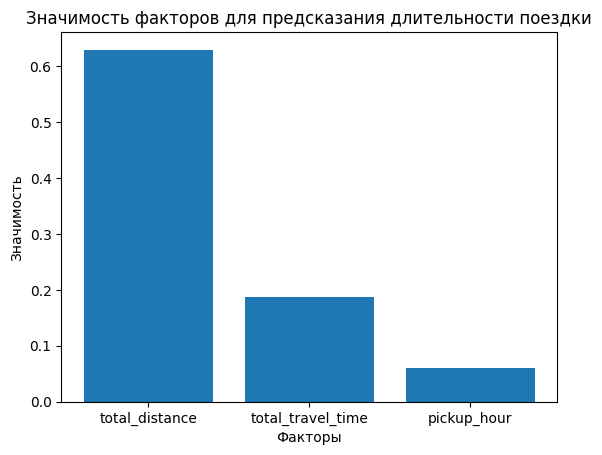

In [12]:
# Получение коэффициентов значимости факторов
feature_importances = model.feature_importances_

# Отсортировать факторы по их значимости
sorted_indices = np.argsort(feature_importances)[::-1]
sorted_feature_importances = feature_importances[sorted_indices]

# Выбрать топ-3 наиболее значимых фактора
top_3_features = sorted_indices[:3]
top_3_importances = sorted_feature_importances[:3]

# Получение названий значимых факторов
feature_names = X_train_selected_normalized_df.columns[top_3_features]

# Построение столбчатой диаграммы
plt.bar(range(len(top_3_features)), top_3_importances, tick_label=feature_names)
plt.xlabel('Факторы')
plt.ylabel('Значимость')
plt.title('Значимость факторов для предсказания длительности поездки')
plt.show()

### Задание 6.5.
Для лучшей из построенных моделей рассчитайте медианную абсолютную ошибку (MeAE - в sklearn функция median_absolute_error) предсказания длительности поездки такси на валидационной выборке:
$$ MeAE = median(|y_i-\hat{y_i}|)$$

Значение метрики MeAE переведите в минуты и округлите до десятых.


In [19]:
# Получение предсказаний модели на валидационной выборке
y_pred_log = model.predict(X_valid_selected_normalized_df)

# Преобразование логарифмических предсказаний и целевой переменной в исходный масштаб
y_pred = np.exp(y_pred_log) - 1
y_valid = np.exp(y_valid_log_df) - 1

# Расчет медианной абсолютной ошибки (MeAE)
meae = median_absolute_error(y_valid, y_pred)

# Перевод значения MeAE в минуты и округление до первого знака после точки-разделителя
meae_minutes = round(meae / 60, 1)

# Вывод значения метрики MeAE в минутах
print("Медианная абсолютная ошибка (MeAE) в минутах: ", meae_minutes)

Медианная абсолютная ошибка (MeAE) в минутах:  1.8


Финальный шаг - сделать submit -  предсказание для отложенного тестового набора данных.

Прочитаем тестовые данные и заранее выделим столбец с идентификаторами поездок из тестового набора данных. Он нам еще пригодится:


In [98]:
test_data = pd.read_csv("/content/drive/MyDrive/ProjectPracticum2/test_data.csv")
osrm_data_test = pd.read_csv("/content/drive/MyDrive/ProjectPracticum2/osrm_data_test.csv")
test_id = test_data['id']

Перед созданием прогноза для тестовой выборки необходимо произвести все манипуляции с данными, которые мы производили с тренировочной выборкой, а именно:
* Перевести признак pickup_datetime в формат datetime;
* Добавить новые признаки (временные, географические, погодные и другие факторы);
* Произвести очистку данных от пропусков;
* Произвести кодировку категориальных признаков:
    * Закодировать бинарные признаки;
    * Закодировать номинальные признаки с помощью обученного на тренировочной выборке OneHotEncoder’а;
* Сформировать матрицу наблюдений, оставив в таблице только те признаки, которые были отобраны с помощью SelectKBest;
* Нормализовать данные с помощью обученного на тренировочной выборке MinMaxScaler’а.


In [99]:
test_data['pickup_datetime']=pd.to_datetime(test_data['pickup_datetime'],format='%Y-%m-%d %H:%M:%S')
test_data = add_datetime_features(test_data)
test_data = add_holiday_features(test_data, holiday_data)
test_data = add_osrm_features(test_data, osrm_data_test)
test_data = add_geographical_features(test_data)
test_data = add_cluster_features(test_data, kmeans)
test_data['pickup_date'] = pd.to_datetime(test_data['pickup_date'])
test_data = add_weather_features(test_data, weather_data)
test_data = fill_null_weather_data(test_data)

test_data['vendor_id'] = test_data['vendor_id'].apply(lambda x: 0 if x == 1 else 1)
test_data['store_and_fwd_flag'] = test_data['store_and_fwd_flag'].apply(lambda x: 0 if x == 'N' else 1)

columns_to_change = ['pickup_day_of_week', 'geo_cluster', 'events']
test_data_onehot = one_hot_encoder.fit_transform(test_data[columns_to_change]).toarray()
column_names = one_hot_encoder.get_feature_names_out(columns_to_change)
test_data_onehot = pd.DataFrame(test_data_onehot, columns=column_names)

test_data = pd.concat(
    [test_data.reset_index(drop=True).drop(columns_to_change, axis=1), test_data_onehot],
    axis=1
)
best_features = X_train_selected_columns
X_test = test_data[best_features]
X_test_scaled = scaler.transform(X_test)
print('Shape of data: {}'.format(X_test.shape))

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but KMeans was fitted without feature names
  warnings.warn(


Shape of data: (625134, 25)


Только после выполнения всех этих шагов можно сделать предсказание длительности поездки для тестовой выборки. Не забудьте перевести предсказания из логарифмического масштаба в истинный, используя формулу:
$$y_i=exp(z_i)-1$$

После того, как вы сформируете предсказание длительности поездок на тестовой выборке вам необходимо будет создать submission-файл в формате csv, отправить его на платформу Kaggle и посмотреть на результирующее значение метрики RMSLE на тестовой выборке.

Код для создания submission-файла:


In [102]:
# Предсказание длительности поездки для тестовой выборки
y_test_predict_log = model.predict(X_test_scaled)

# Преобразование логарифмических предсказаний в исходный масштаб
y_test_predict = np.exp(y_test_predict_log) - 1

test_id = test_data["id"]

submission = pd.DataFrame({'id': test_id, 'trip_duration': y_test_predict})
submission.to_csv('/content/drive/MyDrive/ProjectPracticum2/submission_gb.csv', index=False)

### **В качестве бонуса**

В завершение по ансамблевым мы предлагаем вам попробовать улучшить свое предсказание, воспользовавшись моделью экстремального градиентного бустинга (XGBoost) из библиотеки xgboost.

**XGBoost** - современная модель машинного обучения, которая является продолжением идеи градиентного бустинга Фридмана. У нее есть несколько преимуществ по сравнению с классической моделью градиентного бустинга из библиотеки sklearn: повышенная производительность путем параллелизации процесса обучения, повышенное качество решения за счет усовершенствования алгоритма бустинга, меньшая склонность к переобучению и широкий функционал возможности управления параметрами модели.


Для ее использования необходимо для начала установить пакет xgboost:

In [ ]:
#!pip install xgboost

После чего модуль можно импортировать:

In [ ]:
import xgboost as xgb

Перед обучением модели необходимо перевести наборы данных в тип данных xgboost.DMatrix:

In [ ]:
# Создание матриц наблюдений в формате DMatrix
dtrain = xgb.DMatrix(X_train_scaled, label=y_train_log, feature_names=best_features)
dvalid = xgb.DMatrix(X_valid_scaled, label=y_valid_log, feature_names=best_features)
dtest = xgb.DMatrix(X_test_scaled, feature_names=best_features)

Обучение модели XGBoost происходит с помощью метода train, в который необходимо передать параметры модели, набор данных, количество базовых моделей в ансамбле, а также дополнительные параметры:


In [ ]:
# Гиперпараметры модели
xgb_pars = {'min_child_weight': 20, 'eta': 0.1, 'colsample_bytree': 0.9,
            'max_depth': 6, 'subsample': 0.9, 'lambda': 1, 'nthread': -1,
            'booster' : 'gbtree', 'eval_metric': 'rmse', 'objective': 'reg:squarederror'
           }
# Тренировочная и валидационная выборка
watchlist = [(dtrain, 'train'), (dvalid, 'valid')]
# Обучаем модель XGBoost
model = xgb.train(
    params=xgb_pars, #гиперпараметры модели
    dtrain=dtrain, #обучающая выборка
    num_boost_round=300, #количество моделей в ансамбле
    evals=watchlist, #выборки, на которых считается матрица
    early_stopping_rounds=20, #раняя остановка
    maximize=False, #смена поиска максимума на минимум
    verbose_eval=10 #шаг, через который происходит отображение метрик
)

Предсказать целевой признак на новых данных можно с помощью метода predict():

In [ ]:
#Делаем предсказание на тестовом наборе данных
y_test_predict = np.exp(model.predict(dtest)) - 1
print('Modeling RMSLE %.5f' % model.best_score)

Также как и все модели, основанные на использовании деревьев решений в качестве базовых моделей, XGBoost имеет возможность определения коэффициентов важности факторов. Более того, в библиотеку встроена возможность визуализации важность факторов в виде столбчатой диаграммы. За эту возможность отвечает функция plot_importance():


In [ ]:
fig, ax = plt.subplots(figsize = (15,15))
xgb.plot_importance(model, ax = ax, height=0.5)